# **Análise de desempenho escolar e suas correlações com diferentes variáveis socioeconômicas**

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=668bc2774a62c1d8c14046aacd64d7c48e4dc1156fda43ffc3625e2ca24ebe00
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, roc_auc_score, recall_score, confusion_matrix, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
import lime
import lime.lime_tabular
from scipy.interpolate import make_interp_spline
import tensorflow as tf
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay
import time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LassoCV
from sklearn.inspection import permutation_importance

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Exploração dos dados

In [ ]:
df = pd.read_csv('drive/MyDrive/MICRODADOS_ENEM_2022.csv.gz', sep = ';', encoding="ISO-8859-1", compression='gzip')
df = df.loc[:, ~df.columns.str.startswith('CO_PROVA')]
df = df.loc[:, ~df.columns.str.startswith('TX')]

In [ ]:
df2= df.drop(columns = ['TP_NACIONALIDADE', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_SEXO', 'TP_ANO_CONCLUIU', 'CO_MUNICIPIO_ESC',
'NO_MUNICIPIO_ESC', 'CO_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC',
'TP_SIT_FUNC_ESC',"CO_MUNICIPIO_ESC", "NO_MUNICIPIO_ESC", "CO_UF_ESC", "TP_DEPENDENCIA_ADM_ESC", "TP_SIT_FUNC_ESC",
"CO_MUNICIPIO_PROVA", "NO_MUNICIPIO_PROVA", "CO_UF_PROVA", "SG_UF_PROVA",
"TP_PRESENCA_CN", "TP_PRESENCA_CH", "TP_PRESENCA_LC", "TP_PRESENCA_MT", 'TP_LINGUA', "TP_STATUS_REDACAO"])

df2 = df2[(~pd.isna(df2['NU_NOTA_CN'])) | (~pd.isna(df2['NU_NOTA_CH'])) | (~pd.isna(df2['NU_NOTA_LC'])) | (~pd.isna(df2['NU_NOTA_MT'])) | (~pd.isna(df2['NU_NOTA_REDACAO']))]

df2 = df2[df2['IN_TREINEIRO'] == 0]
df2 = df2.drop(columns = ["IN_TREINEIRO"])
df2 = df2[(df2['TP_ST_CONCLUSAO'] == 1) | (df2['TP_ST_CONCLUSAO'] == 2)]
df2 = df2.reset_index(drop = True)

df2 = df2.dropna()
df2 = df2.sample(n=150000, random_state=42)

df2['Q001'] = df2['Q001'].apply(lambda x: ord(x) - 64)
df2['Q002'] = df2['Q002'].apply(lambda x: ord(x) - 64)
df2['Q006'] = df2['Q006'].apply(lambda x: ord(x) - 64)


In [ ]:
df2

,NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_ST_CONCLUSAO,TP_ESCOLA,TP_ENSINO,SG_UF_ESC,TP_LOCALIZACAO_ESC,NU_NOTA_CN,NU_NOTA_CH,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
274688,210055486785,2022,2,2,3,1.0,PR,1.0,655.5,753.6,...,B,A,B,E,A,A,E,A,C,B
1094303,210057796413,2022,3,2,2,1.0,MG,1.0,487.4,581.7,...,B,A,B,C,A,B,D,A,B,B
863559,210057702944,2022,3,2,2,1.0,AM,1.0,447.3,528.4,...,A,A,A,B,B,A,D,B,A,B
810328,210056543596,2022,2,2,3,1.0,SP,1.0,461.3,567.5,...,B,A,A,C,A,B,D,A,C,B
449279,210055829693,2022,3,2,3,1.0,ES,1.0,513.4,620.9,...,B,A,B,D,B,B,E,B,D,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628616,210056209244,2022,4,2,2,1.0,CE,1.0,562.2,365.9,...,A,A,A,B,A,A,C,A,A,B
1924130,210054937992,2022,2,2,3,1.0,SE,1.0,601.1,637.8,...,B,A,B,D,A,B,D,A,C,B
1272993,210056033977,2022,3,2,2,1.0,SP,1.0,451.5,473.3,...,B,A,B,E,A,A,E,A,B,B
440166,210057660338,2022,3,2,2,2.0,AP,1.0,510.3,514.3,...,A,A,A,C,B,B,E,A,A,B


In [ ]:
mapeamento2 = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8}
df2 = df2.replace(mapeamento2)

mapeamento_renda = {
    1: 'A',
    2: 'A',
    3: 'A',
    4: 'A',
    5: 'A',
    6: 'B',
    7: 'B',
    8: 'B',
    9: 'B',
    10: 'C',
    11: 'C',
    12: 'C',
    13: 'C',
    14: 'D',
    15: 'D',
    16: 'D',
    17: 'D',
}

df2['RENDA'] = df2['Q006'].map(mapeamento_renda)

<ipython-input-8-6f83fcab8288>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df2 = df2.replace(mapeamento2)


In [ ]:
mapeamento_regioes = {
    'AC': 'Norte',
    'AL': 'Nordeste',
    'AP': 'Norte',
    'AM': 'Norte',
    'BA': 'Nordeste',
    'CE': 'Nordeste',
    'DF': 'Centro-Oeste',
    'ES': 'Sudeste',
    'GO': 'Centro-Oeste',
    'MA': 'Nordeste',
    'MT': 'Centro-Oeste',
    'MS': 'Centro-Oeste',
    'MG': 'Sudeste',
    'PA': 'Norte',
    'PB': 'Nordeste',
    'PR': 'Sul',
    'PE': 'Nordeste',
    'PI': 'Nordeste',
    'RJ': 'Sudeste',
    'RN': 'Nordeste',
    'RS': 'Sul',
    'RO': 'Norte',
    'RR': 'Norte',
    'SC': 'Sul',
    'SP': 'Sudeste',
    'SE': 'Nordeste',
    'TO': 'Norte'
}

# Aplicando o mapeamento para criar a nova coluna 'região'
df2['REGIAO'] = df2['SG_UF_ESC'].map(mapeamento_regioes)

<Axes: >

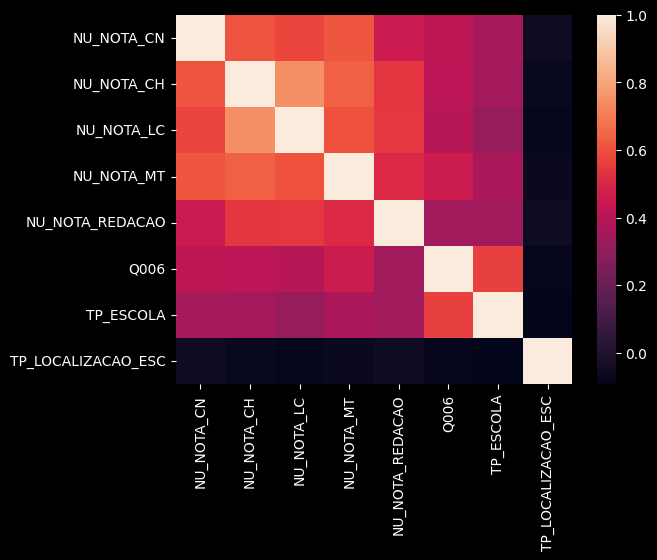

In [ ]:
df3 = df2[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'Q006', 'TP_ESCOLA', 'TP_LOCALIZACAO_ESC']]
plt.style.use('dark_background')
sns.heatmap(df3.corr())

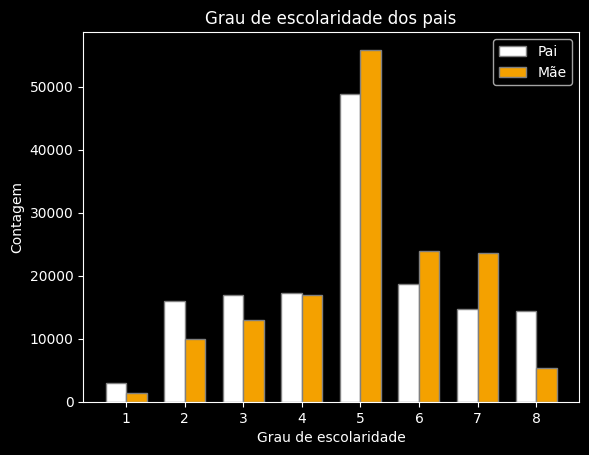

In [ ]:
plt.style.use('dark_background')

pai_counts = df2['Q001'].value_counts().sort_index()
mae_counts = df2['Q002'].value_counts().sort_index()

indices = sorted(set(pai_counts.index).union(set(mae_counts.index)))
pai_counts = pai_counts.reindex(indices, fill_value=0)
mae_counts = mae_counts.reindex(indices, fill_value=0)

bar_width = 0.35
r1 = range(len(pai_counts))
r2 = [x + bar_width for x in r1]

plt.bar(r1, pai_counts, color='white', width=bar_width, edgecolor='grey', label='Pai', align='center')
plt.bar(r2, mae_counts, color='#F4A100', width=bar_width, edgecolor='grey', label='Mãe', align='center')

plt.xlabel('Grau de escolaridade')
plt.ylabel('Contagem')
plt.title('Grau de escolaridade dos pais')
plt.xticks([r + bar_width / 2 for r in r1], indices)
plt.legend()

plt.show()

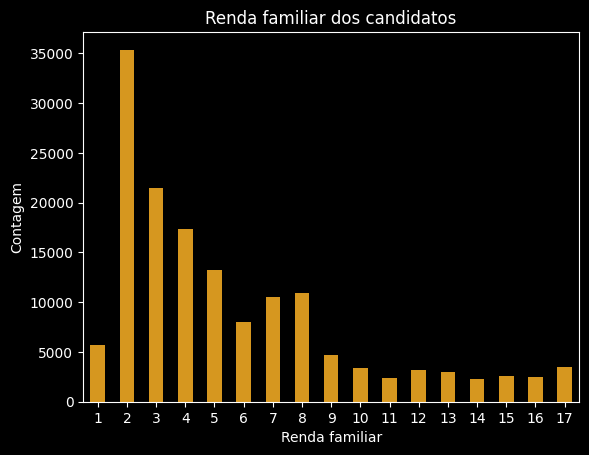

In [ ]:
plt.style.use('dark_background')
sns.countplot(data=df2, x='Q006', color = '#F4A100', width = 0.5, align = 'edge')
plt.title('Renda familiar dos candidatos')
plt.xlabel('Renda familiar')
plt.ylabel('Contagem')

plt.show()

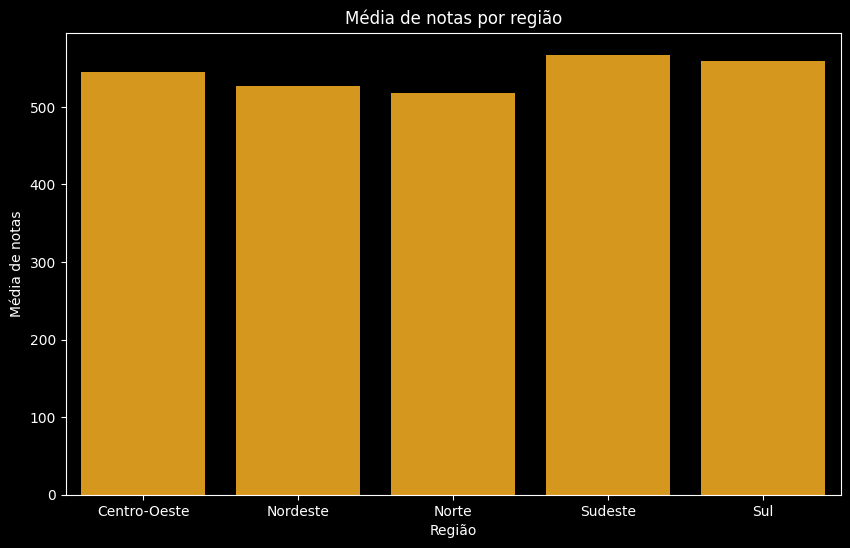

In [ ]:
df2['NOTA_MEDIA'] = df2[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']].mean(axis=1)
media_notas_por_regiao = df2.groupby('REGIAO')['NOTA_MEDIA'].mean().reset_index()

plt.figure(figsize=(10, 6))

sns.barplot(data=media_notas_por_regiao, x='REGIAO', y='NOTA_MEDIA', color = '#F4A100')

plt.title('Média de notas por região')
plt.xlabel('Região')
plt.ylabel('Média de notas')

plt.show()

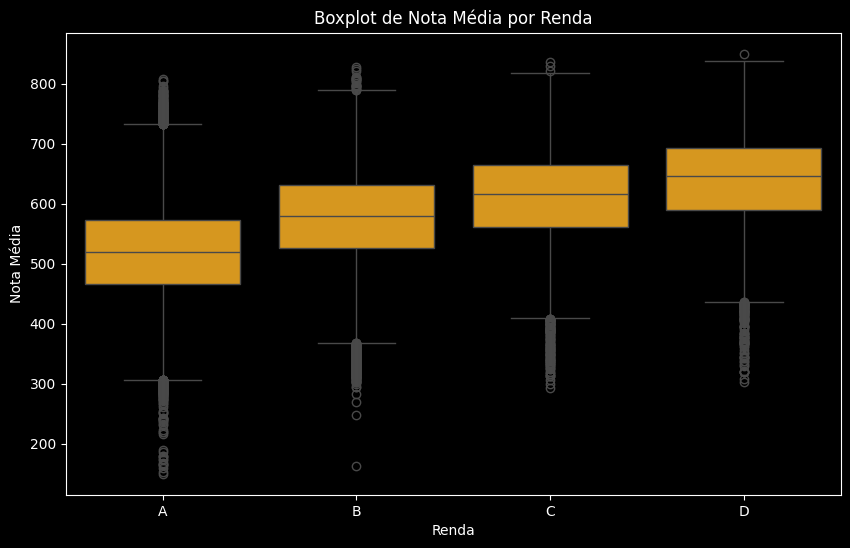

In [ ]:
plt.figure(figsize=(10, 6))

sns.boxplot(x='RENDA', y='NOTA_MEDIA', color = '#F4A100', data=df2,  dodge=True, order=['A','B','C','D'])

plt.xlabel('Renda')
plt.ylabel('Nota Média')

plt.title('Boxplot de Nota Média por Renda')

plt.show()

In [ ]:
print(df2['RENDA'].value_counts())

RENDA
A    93152
B    34154
C    12014
D    10680
Name: count, dtype: int64


In [ ]:
df2['NU_NOTA_MT'].head(100)
df2 = df2.dropna(subset=['NU_NOTA_MT', 'NU_NOTA_CH'])
df2 = df2.reset_index(drop = True)

In [ ]:
df2 = df2.drop(['NU_NOTA_REDACAO', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT','SG_UF_ESC', 'TP_LOCALIZACAO_ESC', 'REGIAO', 'RENDA'],axis=1)
df2 = df2.drop(['NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5'], axis=1)

In [ ]:
df2.value_counts()

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,count
NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_ST_CONCLUSAO,TP_ESCOLA,TP_ENSINO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,NOTA_MEDIA,
210054478401,2022,2,2,3,1.0,5,7,2,4,3,2,1,2,3,1,1,2,2,1,1,2,1,1,2,1,1,4,1,4,2,556.14,1
210056866545,2022,2,2,3,1.0,5,5,3,2,2,8,1,3,3,2,1,2,2,2,2,2,1,2,2,1,1,3,1,2,2,623.74,1
210056866337,2022,3,2,2,1.0,5,5,4,4,3,7,1,3,4,1,2,2,2,2,2,2,1,1,3,1,2,4,1,1,2,531.08,1
210056866338,2022,3,2,2,1.0,2,2,2,6,3,2,1,3,3,2,2,2,2,2,1,1,1,1,2,1,1,2,1,1,2,656.36,1
210056866341,2022,2,2,3,1.0,5,5,2,2,2,2,1,2,3,1,1,2,1,2,1,1,1,1,2,1,1,3,2,1,2,525.98,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210055753980,2022,3,2,2,1.0,5,7,4,4,3,3,1,2,4,2,1,2,1,2,1,2,1,1,3,1,2,4,1,1,2,441.52,1
210055753987,2022,3,2,2,1.0,4,4,4,4,3,15,1,3,4,4,2,2,3,2,1,2,1,2,3,2,2,5,1,3,2,509.94,1
210055753990,2022,3,2,2,1.0,2,4,1,1,5,3,1,2,5,2,1,2,1,3,2,1,1,2,2,1,1,4,1,1,2,439.68,1


In [ ]:
XA = df2.drop('NOTA_MEDIA',axis=1)
YA = df2['NOTA_MEDIA']
normalizador = StandardScaler()

for i in df2.columns:
  if i != 'NOTA_MEDIA':
    df2[[i]] = normalizador.fit_transform(df2[[i]])

In [ ]:
df2.value_counts()

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,count
NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_ST_CONCLUSAO,TP_ESCOLA,TP_ENSINO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,NOTA_MEDIA,
-1.852062,0.0,-0.766702,0.0,1.703193,-0.060052,0.073101,1.276224,-0.914751,0.558084,-0.710389,-0.880969,-0.31831,-0.749387,-0.609793,-1.031076,-0.549114,-0.239649,0.590377,-1.589000,-0.457088,0.747906,-0.226577,-0.722266,-0.615262,-0.522565,-0.662592,0.180418,-0.433781,2.066470,0.268362,556.14,1
0.567041,0.0,-0.766702,0.0,1.703193,-0.060052,0.073101,-0.036993,-0.249655,-0.795077,-1.532370,0.606456,-0.31831,0.372036,-0.609793,0.287188,-0.549114,-0.239649,0.590377,0.519975,2.089929,0.747906,-0.226577,1.384531,-0.615262,-0.522565,-0.662592,-0.772596,-0.433781,0.066325,0.268362,623.74,1
0.566831,0.0,0.366467,0.0,-0.587133,-0.060052,0.073101,-0.036993,0.415441,0.558084,-0.710389,0.358552,-0.31831,0.372036,0.720393,-1.031076,1.301791,-0.239649,0.590377,0.519975,2.089929,0.747906,-0.226577,-0.722266,0.469766,-0.522565,1.509224,0.180418,-0.433781,-0.933748,0.268362,531.08,1
0.566832,0.0,0.366467,0.0,-0.587133,-0.060052,-1.600537,-2.006819,-0.914751,1.911245,-0.710389,-0.880969,-0.31831,0.372036,-0.609793,0.287188,1.301791,-0.239649,0.590377,0.519975,-0.457088,-1.200374,-0.226577,-0.722266,-0.615262,-0.522565,-0.662592,-1.725611,-0.433781,-0.933748,0.268362,656.36,1
0.566835,0.0,-0.766702,0.0,1.703193,-0.060052,0.073101,-0.036993,-0.914751,-0.795077,-1.532370,-0.880969,-0.31831,-0.749387,-0.609793,-1.031076,-0.549114,-0.239649,-1.027330,0.519975,-0.457088,-1.200374,-0.226577,-0.722266,-0.615262,-0.522565,-0.662592,-0.772596,2.305311,-0.933748,0.268362,525.98,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-0.559947,0.0,0.366467,0.0,-0.587133,-0.060052,0.073101,1.276224,0.415441,0.558084,-0.710389,-0.633065,-0.31831,-0.749387,0.720393,0.287188,-0.549114,-0.239649,-1.027330,0.519975,-0.457088,0.747906,-0.226577,-0.722266,0.469766,-0.522565,1.509224,0.180418,-0.433781,-0.933748,0.268362,441.52,1
-0.559940,0.0,0.366467,0.0,-0.587133,-0.060052,-0.484779,-0.693602,0.415441,0.558084,-0.710389,2.341786,-0.31831,0.372036,0.720393,2.923717,1.301791,-0.239649,2.208083,0.519975,-0.457088,0.747906,-0.226577,1.384531,0.469766,1.913637,1.509224,1.133433,-0.433781,1.066397,0.268362,509.94,1
-0.559937,0.0,0.366467,0.0,-0.587133,-0.060052,-1.600537,-0.693602,-1.579847,-1.471657,0.933573,-0.633065,-0.31831,-0.749387,2.050579,0.287188,-0.549114,-0.239649,-1.027330,2.628950,2.089929,-1.200374,-0.226577,1.384531,-0.615262,-0.522565,-0.662592,0.180418,-0.433781,-0.933748,0.268362,439.68,1


In [ ]:
X = df2.drop('NOTA_MEDIA',axis=1)
Y = df2['NOTA_MEDIA']
X1 = df2.drop('NOTA_MEDIA',axis=1)
Y2 = df2['NOTA_MEDIA']

In [ ]:
print(len(df2))

150000


In [ ]:
contagem_valores = X['Q024'].value_counts().sort_index()

print(contagem_valores)

Q024
-0.933748    59006
 0.066325    58803
 1.066397    19744
 2.066470     8027
 3.066542     4420
Name: count, dtype: int64


##Modelos paramétricos

### Ridge

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

Score máximo: 5435.870628616387, com lambda = 787.879393939394


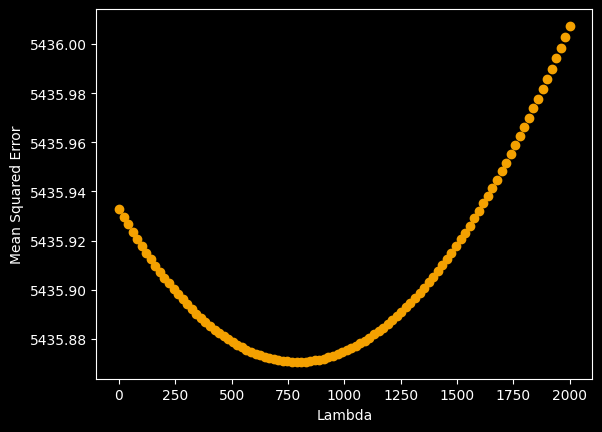

In [ ]:
lambdas = np.linspace(0.001, 2000, 100)
scores = []
min = 100000
index = 0

for i in lambdas:
  modelo1 = Ridge(alpha=i)
  modelo1.fit(X_train, y_train)
  Y_pred = modelo1.predict(X_test)
  score = mean_squared_error(y_test, Y_pred)
  scores.append(score)
  if score < min:
    min = score
    index = i

print(f'Score máximo: {min}, com lambda = {index}')

plt.scatter(lambdas,scores,color = '#F4A100')
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')

plt.show()

In [ ]:
ridge_model = Ridge(alpha=index)
ridge_model.fit(X_train, y_train)

Ridge(alpha=787.879393939394)

In [ ]:
Y_pred = ridge_model.predict(X_test)

In [ ]:
X = df2.drop(columns=['NOTA_MEDIA'])
Y = df2['NOTA_MEDIA']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

Y_pred = ridge_model.predict(X_test)

In [ ]:
coefficients_ridge = ridge_model.coef_

intercept_ridge = ridge_model.intercept_

print(f'Intercept : {intercept_ridge}\n')

for i in range(len(coefficients_ridge)):
  print(f'{df2.columns[i]} : {coefficients_ridge[i]}\n')

Intercept : 547.2133197954699

NU_INSCRICAO : -1.0707236440257413

NU_ANO : 0.0

TP_FAIXA_ETARIA : -8.252261711119628

TP_ST_CONCLUSAO : 0.0

TP_ESCOLA : 16.005245857965644

TP_ENSINO : -0.985459919286355

Q001 : 0.45016188190037365

Q002 : 4.208720101839728

Q003 : 0.47337510072888594

Q004 : -0.3086003528329505

Q005 : -6.481803846811994

Q006 : 19.20228318718735

Q007 : -0.8890196591941859

Q008 : 3.7367949951232724

Q009 : -1.4450019397074878

Q010 : 0.9074670148179307

Q011 : -3.3955464114998737

Q012 : -3.9935002394257744

Q013 : 6.602416556799567

Q014 : -1.294759625368068

Q015 : -3.2983810535376974

Q016 : 0.6911195786905671

Q017 : -1.4234129045905008

Q018 : 0.8974261537189298

Q019 : -1.0368352082649728

Q020 : -0.9468878404346178

Q021 : -4.411369590417249

Q022 : 4.1691887637901095

Q023 : 1.7760542727820472

Q024 : 13.443286845965623

Q025 : 4.963362884757262



In [ ]:
# Coeficientes do Forward Stepwise
forward_stepwise = {
    'Q018': 0.8869,
    'Q019': -1.0742,
    # Q001 não está listado
    'Q007': -1.0589
}

# Coeficientes do Ridge
ridge = {
    'Q018': 0.8974,
    'Q019': -1.0368,
    'Q001': 0.4502,
    'Q007': -0.8890
}

# Calcular as razões
ratios = {}
for key in forward_stepwise:
    if key in ridge:
        ratio = forward_stepwise[key] / ridge[key]
        ratios[key] = ratio

# Mostrar as razões calculadas
for key, ratio in ratios.items():
    print(f'Razão (Forward Stepwise / Ridge) para {key}: {ratio:.4f}')


Razão (Forward Stepwise / Ridge) para Q018: 0.9883
Razão (Forward Stepwise / Ridge) para Q019: 1.0361
Razão (Forward Stepwise / Ridge) para Q007: 1.1911


In [ ]:
# Calculando o MSE
mse_ridge = mean_squared_error(y_test, Y_pred)
print("Mean Squared Error (RIDGE):", mse_ridge)

# Calculando o MAE
mae_ridge = mean_absolute_error(y_test, Y_pred)
print("Mean Absolute Error (RIDGE):", mae_ridge)

# Calculando o R²
r2_ridge = r2_score(y_test, Y_pred)
print("R-squared (RIDGE):", r2_ridge)

#Calculando o SE
se_ridge = np.sqrt(np.mean((y_test - Y_pred)))
print("Erro Padrão (RIDGE):", se_ridge)

n_samples = len(y_test)

log_likelihood = -n_samples / 2 * np.log(mse_ridge)
n_features = np.count_nonzero(ridge_model.coef_)
bic_ridge = n_samples * np.log(mse_ridge) + n_features * np.log(n_samples)

print("BIC (RIDGE):", bic_ridge)

Mean Squared Error (RIDGE): 5435.870628616387
Mean Absolute Error (RIDGE): 58.09401137578584
R-squared (RIDGE): 0.3203465563255724
Erro Padrão (RIDGE): 0.45189271152139404
BIC (RIDGE): 258322.20890668547


### Regressão Linear e Forward Stepwise

In [ ]:
X = df2.drop('NOTA_MEDIA',axis=1)
Y = df2['NOTA_MEDIA']

X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

coefficients_linear = results.params

                            OLS Regression Results                            
Dep. Variable:             NOTA_MEDIA   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     2460.
Date:                Thu, 02 Jan 2025   Prob (F-statistic):               0.00
Time:                        21:40:36   Log-Likelihood:            -8.5820e+05
No. Observations:              150000   AIC:                         1.716e+06
Df Residuals:                  149970   BIC:                         1.717e+06
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             547.2542      0.191   28

In [ ]:
mse = results.mse_resid

print("Erro Quadrático Médio (MSE):", mse)

residuals = results.resid

mae = np.mean(np.abs(residuals))

print("Erro Absoluto Médio (MAE):", mae)

Erro Quadrático Médio (MSE): 5458.9578674352615
Erro Absoluto Médio (MAE): 58.21592899689573


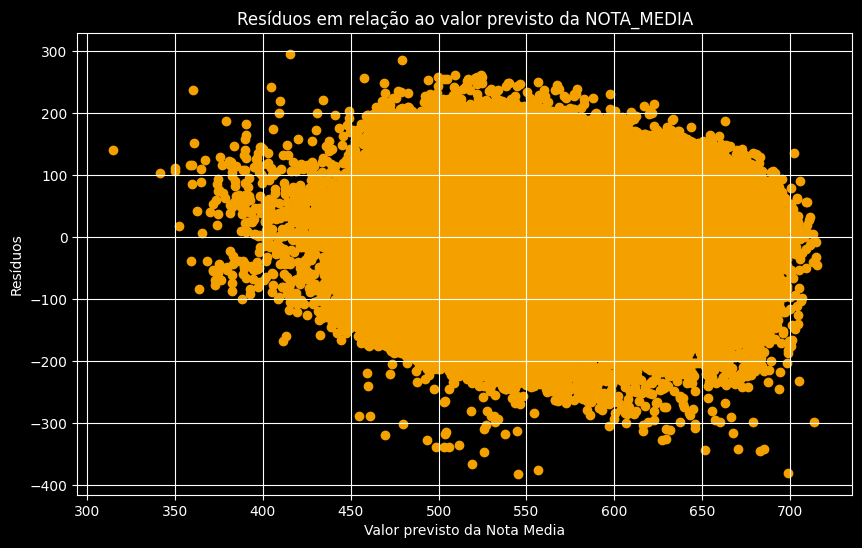

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(results.fittedvalues, residuals,color = '#F4A100')
plt.xlabel("Valor previsto da Nota Media")
plt.ylabel("Resíduos")
plt.title("Resíduos em relação ao valor previsto da NOTA_MEDIA")
plt.grid(True)
plt.show()

In [ ]:
import statsmodels.api as sm
import pandas as pd

# Supondo que df2 já está carregado

# Definindo as covariáveis e a variável dependente
covariaveis = df2.drop('NOTA_MEDIA', axis=1).columns.tolist()
X = df2.drop('NOTA_MEDIA', axis=1)
Y = df2['NOTA_MEDIA']

# Função para adicionar uma constante ao modelo
def add_constant(X):
    return sm.add_constant(X)

# Função para calcular o AIC de um modelo
def calculate_aic(model):
    return model.aic

# Função para realizar o forward stepwise
def forward_stepwise(X, Y):
    initial_features = []
    remaining_features = list(X.columns)
    best_features = []
    best_aic = float('inf')

    while remaining_features:
        aic_with_candidates = []
        for candidate in remaining_features:
            features_to_try = initial_features + [candidate]
            X_new = add_constant(X[features_to_try])
            model = sm.OLS(Y, X_new).fit()
            aic = calculate_aic(model)
            aic_with_candidates.append((aic, candidate))

        aic_with_candidates.sort()
        best_new_aic, best_candidate = aic_with_candidates[0]

        if best_new_aic < best_aic:
            best_aic = best_new_aic
            initial_features.append(best_candidate)
            remaining_features.remove(best_candidate)
            best_features.append(best_candidate)
        else:
            break

    return best_features, best_aic, remaining_features

# Executando a seleção stepwise forward
best_features, best_aic, removed_features = forward_stepwise(X, Y)

# Exibindo os resultados
print("Melhores variáveis selecionadas:", best_features)
print("Melhor AIC:", best_aic)
print("Covariáveis removidas:", removed_features)

# Ajustando o modelo final com as melhores variáveis
X_final = add_constant(X[best_features])
model_final = sm.OLS(Y, X_final).fit()

# Exibindo o sumário do modelo final
print(model_final.summary())



Melhores variáveis selecionadas: ['Q006', 'TP_ESCOLA', 'Q024', 'TP_FAIXA_ETARIA', 'Q005', 'Q025', 'Q013', 'Q021', 'Q002', 'Q012', 'Q015', 'Q011', 'Q022', 'Q008', 'Q023', 'Q017', 'Q009', 'NU_INSCRICAO', 'TP_ENSINO', 'Q007', 'Q020', 'Q014', 'Q010', 'Q019', 'Q018', 'Q001', 'Q016']
Melhor AIC: 1716462.0996848736
Covariáveis removidas: ['NU_ANO', 'TP_ST_CONCLUSAO', 'Q003', 'Q004']
                            OLS Regression Results                            
Dep. Variable:             NOTA_MEDIA   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     2642.
Date:                Thu, 02 Jan 2025   Prob (F-statistic):               0.00
Time:                        21:42:17   Log-Likelihood:            -8.5820e+05
No. Observations:              150000   AIC:                         1.716e+06
Df Residuals:                  149972   BIC:                        

In [ ]:
print(len(best_features))

27


In [ ]:
mse = model_final.mse_resid

print("Erro Quadrático Médio (MSE):", mse)

residuals = model_final.resid

mae = np.mean(np.abs(residuals))

print("Erro Absoluto Médio (MAE):", mae)

Erro Quadrático Médio (MSE): 5458.97842133866
Erro Absoluto Médio (MAE): 58.21552200554351


### Lasso

Dividindo os dados em conjuntos de treinamento e teste e setando a semente (seed) que, nesse caso é o valor 1 no parâmentro `random_state`


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 327191674.2496149, tolerance: 96456.67981483944
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did 

Score máximo: 0.3223513465945069, com lambda = 0.0


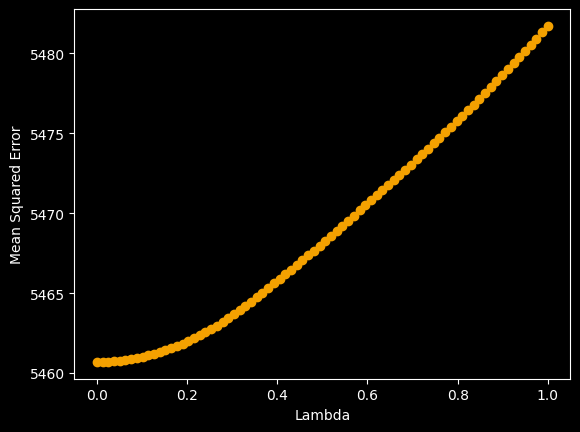

In [ ]:
lambdas = np.linspace(0, 1, 80)

# Criando e ajustando o modelo LassoCV
modelo_cv = LassoCV(alphas=lambdas, cv=5)  # Você pode ajustar o número de folds da validação cruzada
modelo_cv.fit(X, Y)

# Recuperando o melhor alpha e o score correspondente
best_alpha = modelo_cv.alpha_
best_score = modelo_cv.score(X, Y)

print(f'Score máximo: {best_score}, com lambda = {best_alpha}')

# Plotando os resultados
plt.scatter(modelo_cv.alphas_, modelo_cv.mse_path_.mean(axis=1), color='#F4A100')
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')
plt.show()

In [ ]:
lasso_model = LassoCV(alphas=np.linspace(0, 1, 80), cv=5)
lasso_model.fit(X_train, y_train)

# Previsões do modelo
predictions_lasso = lasso_model.predict(X_test)

# Coeficientes e intercepto
coefficients_lasso = lasso_model.coef_
intercept_lasso = lasso_model.intercept_

print(f'Intercept : {intercept_lasso}\n')

# Imprimindo os coeficientes
for i in range(len(coefficients_lasso)):
    print(f'{df2.columns[i]} : {coefficients_lasso[i]}\n')

# Calculando o MSE
mse_lasso = mean_squared_error(y_test, predictions_lasso)
print("Mean Squared Error (LASSO):", mse_lasso)

# Calculando o MAE
mae_lasso = mean_absolute_error(y_test, predictions_lasso)
print("Mean Absolute Error (LASSO):", mae_lasso)

# Calculando o R²
r2_lasso = r2_score(y_test, predictions_lasso)
print("R-squared (LASSO):", r2_lasso)

# Calculando o SE
se_lasso = np.sqrt(mse_lasso)
print("Erro Padrão (LASSO):", se_lasso)

# Calculando o BIC
n_samples = len(y_test)
n_features = np.count_nonzero(coefficients_lasso)  # Conta o número de características não nulas
log_likelihood = -n_samples / 2 * np.log(mse_lasso)
bic_lasso = n_samples * np.log(mse_lasso) + n_features * np.log(n_samples)

print("BIC (LASSO):", bic_lasso)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 261724985.25328967, tolerance: 77370.87611300002
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did

Intercept : 547.2138040419176

NU_INSCRICAO : -1.0774043841850283

NU_ANO : 0.0

TP_FAIXA_ETARIA : -8.289865048728249

TP_ST_CONCLUSAO : 0.0

TP_ESCOLA : 16.08792855784791

TP_ENSINO : -0.9867611519288021

Q001 : 0.41678372981247214

Q002 : 4.198679829973845

Q003 : 0.4576700996009664

Q004 : -0.3567761710275261

Q005 : -6.512761264985454

Q006 : 19.463862272685734

Q007 : -0.9480765433778018

Q008 : 3.7171643634782767

Q009 : -1.4782130154233755

Q010 : 0.84623428453759

Q011 : -3.400041637830929

Q012 : -4.024803482546214

Q013 : 6.660776239273483

Q014 : -1.3364857895576565

Q015 : -3.3309529935107176

Q016 : 0.673629563227421

Q017 : -1.456389539792035

Q018 : 0.8488071676976399

Q019 : -1.0983297545587065

Q020 : -0.9653589716743817

Q021 : -4.490761951963919

Q022 : 4.191115935812429

Q023 : 1.7761040900872522

Q024 : 13.532106606380614

Q025 : 4.988140263163947

Mean Squared Error (LASSO): 5435.93291167273
Mean Absolute Error (LASSO): 58.09334618375955
R-squared (LASSO): 0.32033

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.278e+08, tolerance: 9.682e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


### Resultados

In [ ]:
print(len(df2.columns))

32


In [ ]:
coef_df = pd.DataFrame({
    "COV" : (df2.drop("NOTA_MEDIA", axis = 1)).columns,
    'Coeficientes Ridge': coefficients_ridge,
    'Coeficientes Lasso': coefficients_lasso
})
print(len(df2.columns))
# Cálculo da razão em porcentagem (Lasso / Ridge * 100)
coef_df['Razão Lasso/Ridge (%)'] = (coef_df['Coeficientes Lasso'] /
                                    coef_df['Coeficientes Ridge'].replace(0, np.nan)) * 100

# Tratamento de possíveis divisões por zero, substituindo inf e NaN por zero
coef_df['Razão Lasso/Ridge (%)'].replace([np.inf, -np.inf], np.nan, inplace=True)
coef_df['Razão Lasso/Ridge (%)'].fillna(0, inplace=True)

# Exibição da tabela
coef_df

32


<ipython-input-47-2fd840ef369f>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  coef_df['Razão Lasso/Ridge (%)'].replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-47-2fd840ef369f>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].met

,COV,Coeficientes Ridge,Coeficientes Lasso,Razão Lasso/Ridge (%)
0,NU_INSCRICAO,-1.070724,-1.077404,100.623946
1,NU_ANO,0.000000,0.000000,0.000000
2,TP_FAIXA_ETARIA,-8.252262,-8.289865,100.455673
3,TP_ST_CONCLUSAO,0.000000,0.000000,0.000000
4,TP_ESCOLA,16.005246,16.087929,100.516597
5,TP_ENSINO,-0.985460,-0.986761,100.132043
6,Q001,0.450162,0.416784,92.585300
7,Q002,4.208720,4.198680,99.761441
8,Q003,0.473375,0.457670,96.682335
9,Q004,-0.308600,-0.356776,115.611070


In [ ]:
print(type(coefficients_ridge))

<class 'numpy.ndarray'>


In [ ]:
print(df2.columns.tolist())

['NU_INSCRICAO', 'NU_ANO', 'TP_FAIXA_ETARIA', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'TP_ENSINO', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'NOTA_MEDIA']


In [ ]:
import pandas as pd

# Coeficientes da Regressão Linear
coefficients_linear = [
    -1.0038, 0.0, -8.2631, 0.0, 16.1206, -0.9450, 0.4044, 4.1045,
    0.3346, -0.2604, -6.4240, 19.3033, -1.0643, 3.8470, -1.4368, 1.0378,
    -3.5287, -4.1089, 6.7822, -1.2239, -3.3134, 0.4346, -1.4721, 0.8891,
    -1.0801, -0.9614, -4.5442, 4.0203, 1.6569, 13.5532, 5.0963
]

# Coeficientes do Forward Stepwise (apenas os coeficientes presentes)
coefficients_stepwise = [
    19.3006, 16.1215, 13.5541, -8.2613, -6.4289, 5.1028, 6.7824,
    -4.5440, 4.0412, -4.1086, -3.3120, -3.5431, 4.0214, 3.8507, 1.6589,
    -1.4724, -1.4436, -1.0023, -0.9447, -1.0589, -0.9626, -1.2153, 1.0235,
    -1.0742, 0.8869, 0.5036, 0.0, 4.169189, 1.776054, 13.443287, 4.963363
]

# Coeficientes do Lasso (apenas os coeficientes presentes)
coefficients_lasso = [
    -1.077404, 0.0, -8.289865, 0.0, 16.087929, -0.986761, 0.416784,
    4.198680, 0.457670, -0.356776, -6.512761, 19.463862, -0.948077, 3.717164,
    -1.478213, 0.846234, -3.400042, -4.024803, 6.660776, -1.336486, -3.330953,
    0.673630, -1.456390, 0.848807, -1.098330, -0.965359, -4.490762, 4.191116,
    1.776104, 13.532107, 4.988140
]

# Coeficientes do Ridge (apenas os coeficientes presentes)
coefficients_ridge = [
    -1.070724, 0.0, -8.252262, 0.0, 16.005246, -0.985460, 0.450162,
    4.208720, 0.473375, -0.308600, -6.481804, 19.202283, -0.889020, 3.736795,
    -1.445002, 0.907467, -3.395546, -3.993500, 6.602417, -1.294760, -3.298381,
    0.691120, -1.423413, 0.897426, -1.036835, -0.946888, -4.411370, 4.169189,
    1.776054, 13.443287, 4.963363
]

# Criando uma lista de nomes das variáveis
variables = [
    'NU_INSCRICAO', 'NU_ANO', 'TP_FAIXA_ETARIA', 'TP_ST_CONCLUSAO',
    'TP_ESCOLA', 'TP_ENSINO', 'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006',
    'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015',
    'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024',
    'Q025'
]

# Substituindo os coeficientes ausentes por 0
coefficients_linear = [coef if coef != 0 else 0 for coef in coefficients_linear]
coefficients_stepwise = [coef if coef != 0 else 0 for coef in coefficients_stepwise]
coefficients_lasso = [coef if coef != 0 else 0 for coef in coefficients_lasso]
coefficients_ridge = [coef if coef != 0 else 0 for coef in coefficients_ridge]

# Criando o DataFrame com os coeficientes
df_coefficients = pd.DataFrame({
    'Regressão Linear': coefficients_linear,
    'Forward Stepwise': coefficients_stepwise,
    'Lasso': coefficients_lasso,
    'Ridge': coefficients_ridge
}, index=variables)

# Exibindo o DataFrame
print(df_coefficients)


                 Regressão Linear  Forward Stepwise      Lasso      Ridge
NU_INSCRICAO              -1.0038         19.300600  -1.077404  -1.070724
NU_ANO                     0.0000         16.121500   0.000000   0.000000
TP_FAIXA_ETARIA           -8.2631         13.554100  -8.289865  -8.252262
TP_ST_CONCLUSAO            0.0000         -8.261300   0.000000   0.000000
TP_ESCOLA                 16.1206         -6.428900  16.087929  16.005246
TP_ENSINO                 -0.9450          5.102800  -0.986761  -0.985460
Q001                       0.4044          6.782400   0.416784   0.450162
Q002                       4.1045         -4.544000   4.198680   4.208720
Q003                       0.3346          4.041200   0.457670   0.473375
Q004                      -0.2604         -4.108600  -0.356776  -0.308600
Q005                      -6.4240         -3.312000  -6.512761  -6.481804
Q006                      19.3033         -3.543100  19.463862  19.202283
Q007                      -1.0643     

In [ ]:
ridge_coefs = {
    'Q018': 0.8974,
    'Q019': -1.0369,
    'Q001': 0.4501,
    'Q007': -0.8890
}

linear_coefs = {
    'Q018': 0.8891,
    'Q019': -1.0801,
    'Q001': 0.4044,
    'Q007': -1.0643
}

ratios = {}
for var in ['Q018', 'Q019', 'Q001', 'Q007']:
    ridge_coef = ridge_coefs[var]
    linear_coef = linear_coefs[var]
    ratio = ridge_coef / linear_coef
    ratios[var] = ratio

for var, ratio in ratios.items():
    print(f'Razão para {var}: {ratio:.4f}')

Razão para Q018: 1.0093
Razão para Q019: 0.9600
Razão para Q001: 1.1130
Razão para Q007: 0.8353


## Modelos não paramétricos

###Método KNN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

valores_k = range(60, 80)

pontuacoes = []

for k in valores_k:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    pontuacao = r2_score(y_test, knn.predict(X_test))

    pontuacoes.append(pontuacao)

melhor_k = valores_k[np.argmax(pontuacoes)]
print("Melhor valor de k:", melhor_k)

Melhor valor de k: 79


Score máximo: 0.30893219707189734, com lambda = 79


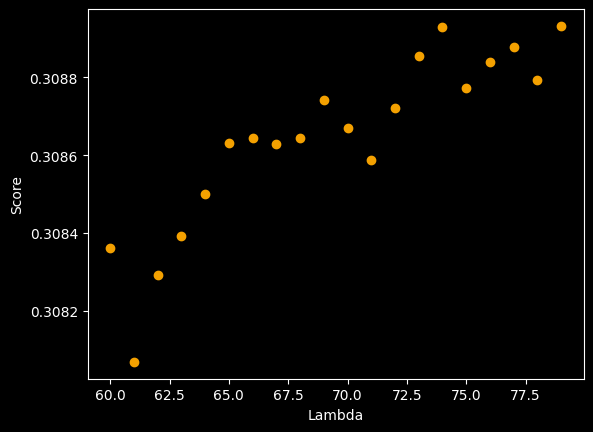

In [ ]:
print(f'Score máximo: {np.max(pontuacoes)}, com lambda = {melhor_k}')

plt.scatter(valores_k,pontuacoes,color = '#F4A100')
plt.xlabel('Lambda')
plt.ylabel('Score')

plt.show()

In [ ]:
ajuste = KNeighborsRegressor(n_neighbors=76)

ajuste.fit(X_train, y_train)

predito = ajuste.predict(X_test)

In [ ]:
print("R²:", r2_score(y_test, predito))
print("MSE:", mean_squared_error(y_test, predito))

R²: 0.3088401876104767
MSE: 5527.89860599596


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


Intercept 516.3345048244315
Prediction_local [624.00915778]
Right: 609.0926315789474


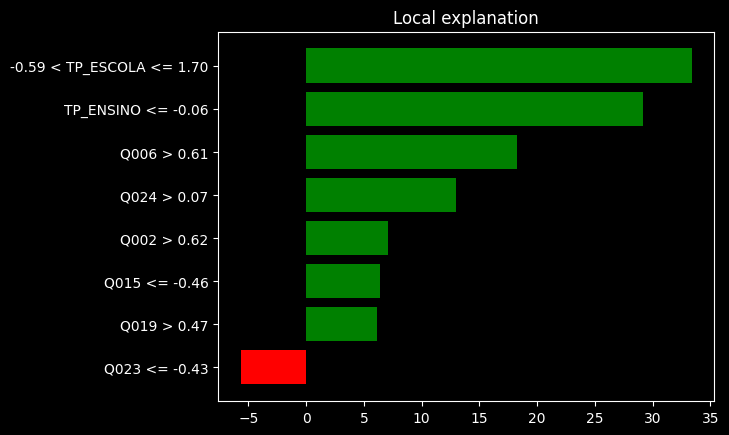

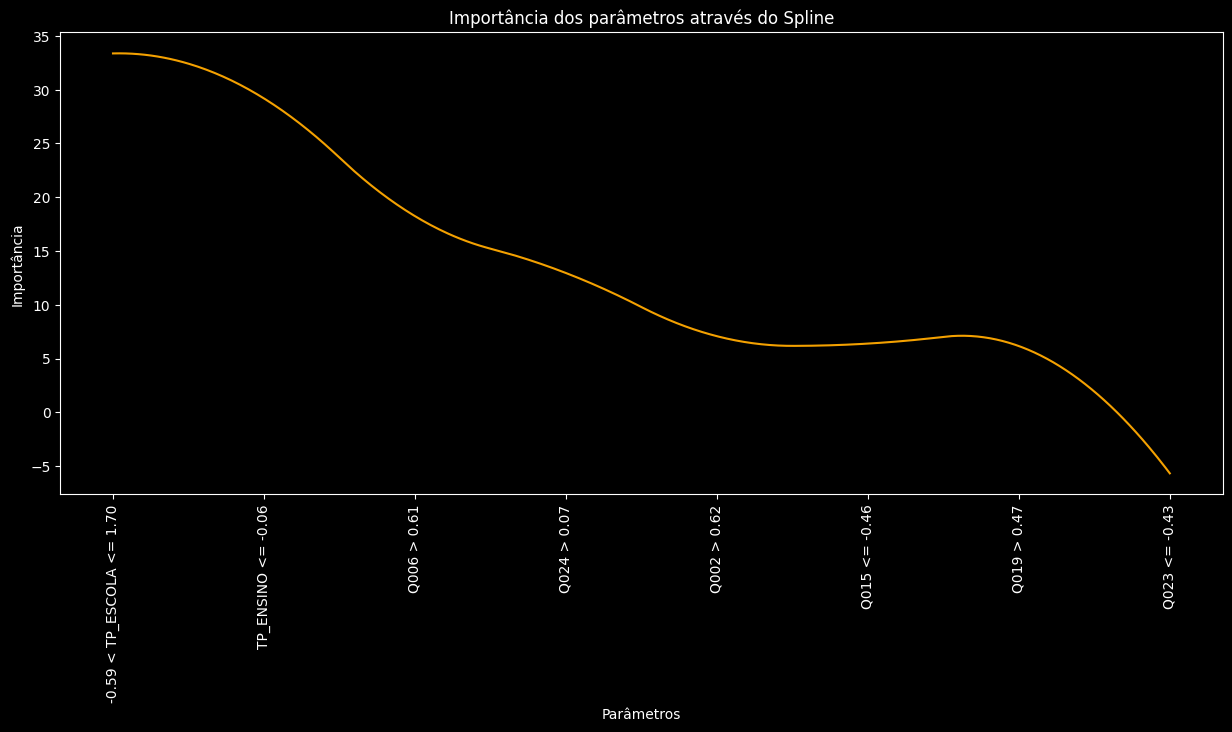

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X.columns, class_names=['price'], verbose=True, mode='regression', random_state = 1)
idx = 0
exp = explainer.explain_instance(X_test.values[idx], ajuste.predict, num_features=8)

exp.as_pyplot_figure()
plt.show()

feature_importance = exp.as_list()
features, importances = zip(*feature_importance)
features = np.array(features)
importances = np.array(importances)

x = np.arange(len(features))
spl = make_interp_spline(x, importances, k=2)
x_new = np.linspace(x.min(), x.max(), 500)
y_smooth = spl(x_new)

plt.figure(figsize=(15, 6))
plt.plot(x_new, y_smooth, color = '#F4A100')
plt.xticks(x, features, rotation=90)
plt.xlabel('Parâmetros')
plt.ylabel('Importância')
plt.title('Importância dos parâmetros através do Spline')
plt.show()

Computing partial dependence plots and individual conditional expectation...
done in 2678.965s


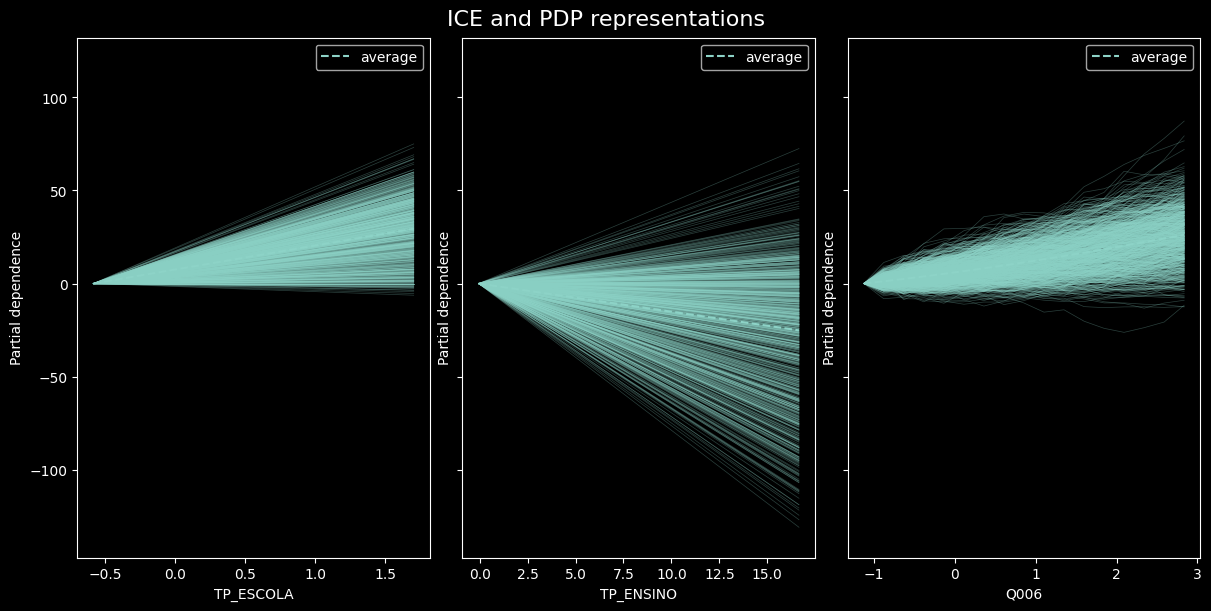

In [ ]:
tic = time.time()
_, ax = plt.subplots(ncols=3, figsize=(12, 6), sharey=True, constrained_layout=True)

features_info = {
    "features": [4, 5, 11],
    "kind": "both",
    "centered": True,
}

display = PartialDependenceDisplay.from_estimator(
    knn,
    X_train,
    **features_info,
    ax=ax,
)
print(f"done in {time.time() - tic:.3f}s")
_ = display.figure_.suptitle("ICE and PDP representations", fontsize=16)
plt.show()

###Random Forest

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

In [ ]:
clf = RandomForestRegressor(random_state=1)

param_grid = {
    'n_estimators': [int(x) for x in np.linspace(100, 500, 5)]
}

best_n_estimators = 100

clf_best = RandomForestRegressor(n_estimators=best_n_estimators, random_state=1)
clf_best.fit(X_train, y_train)

y_pred = clf_best.predict(X_test)

In [ ]:
print("R²:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R²: 0.3226977840029882
MSE: 5417.06550139779


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Intercept 521.0736501004404
Prediction_local [616.17161479]
Right: 643.1310000000002


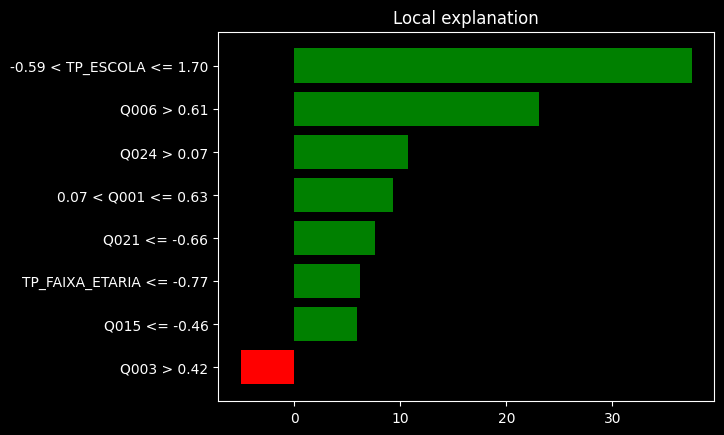

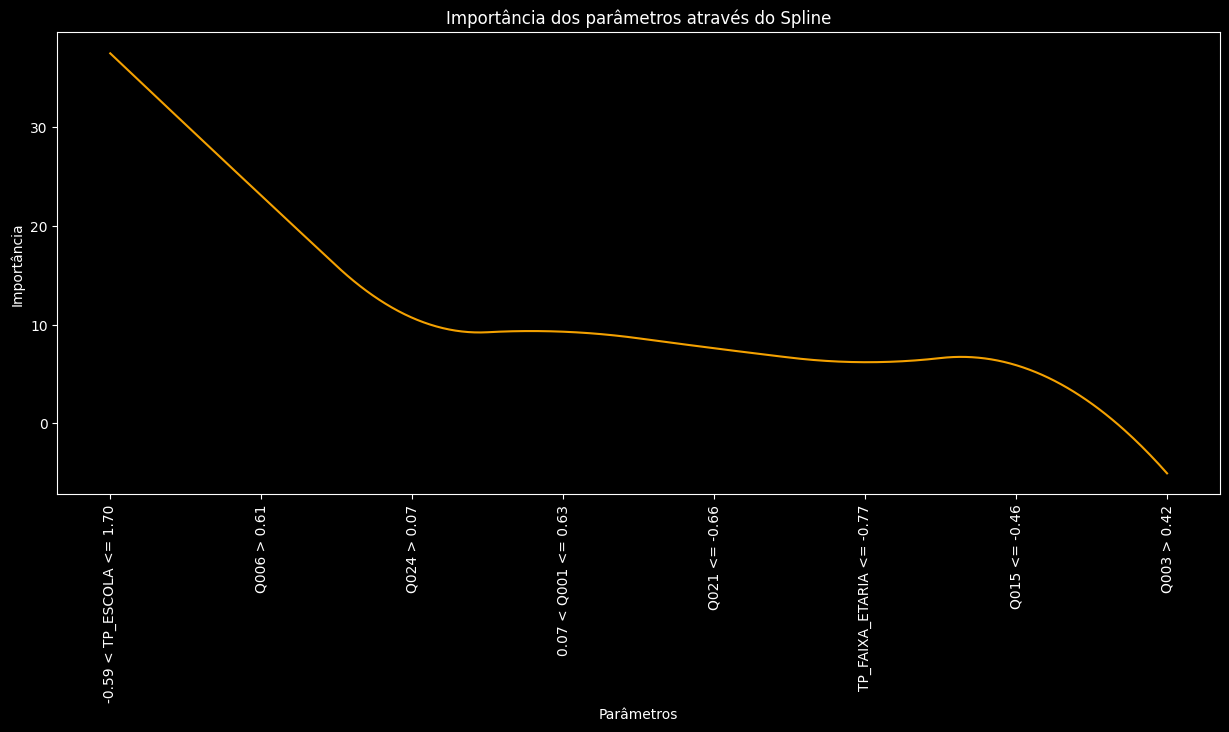

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X.columns, class_names=['price'], verbose=True, mode='regression', random_state = 1)
idx = 0
exp = explainer.explain_instance(X_test.values[idx], clf_best.predict, num_features=8)

exp.as_pyplot_figure()
plt.show()

feature_importance = exp.as_list()
features, importances = zip(*feature_importance)
features = np.array(features)
importances = np.array(importances)

x = np.arange(len(features))
spl = make_interp_spline(x, importances, k=2)
x_new = np.linspace(x.min(), x.max(), 500)
y_smooth = spl(x_new)

plt.figure(figsize=(15, 6))
plt.plot(x_new, y_smooth, color = '#F4A100')
plt.xticks(x, features, rotation=90)
plt.xlabel('Parâmetros')
plt.ylabel('Importância')
plt.title('Importância dos parâmetros através do Spline')
plt.show()

Computing partial dependence plots and individual conditional expectation...
done in 95.371s


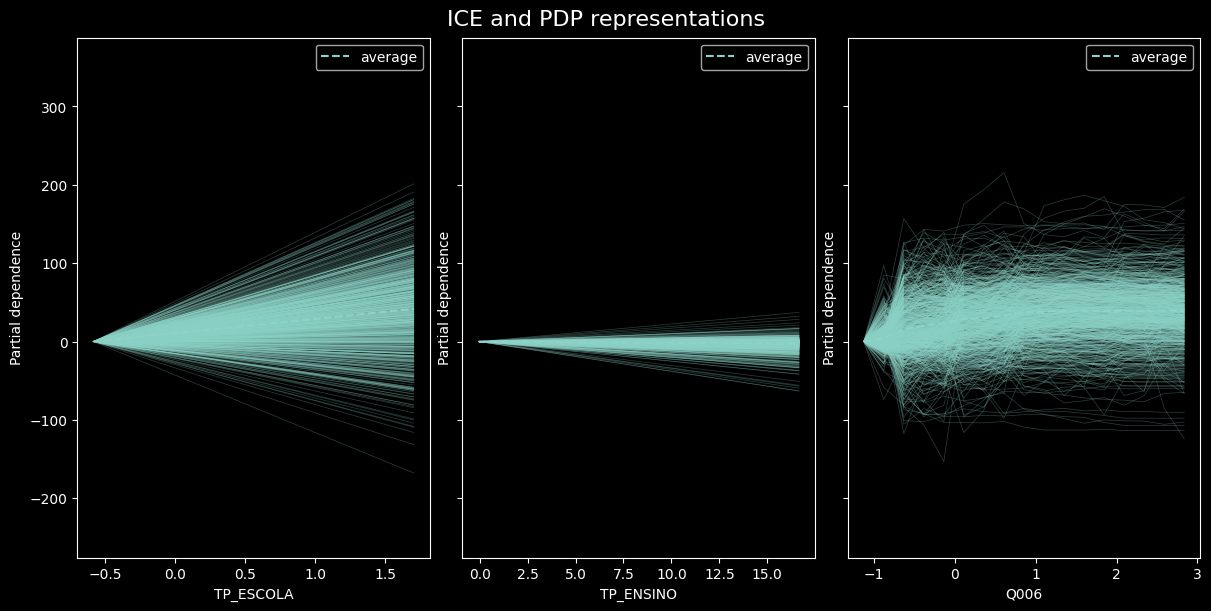

In [ ]:
tic = time.time()
_, ax = plt.subplots(ncols=3, figsize=(12, 6), sharey=True, constrained_layout=True)

features_info = {
    "features": [4, 5, 11],
    "kind": "both",
    "centered": True,
}

display = PartialDependenceDisplay.from_estimator(
    clf_best,
    X_train,
    **features_info,
    ax=ax,
)
print(f"done in {time.time() - tic:.3f}s")
_ = display.figure_.suptitle("ICE and PDP representations", fontsize=16)
plt.show()

In [ ]:
print(X_test.values[0])
print(y_test.values[0])

[-0.56172253  0.         -0.76670219  0.          1.70319288 -0.06005241
  0.63098022  1.27622408  1.08053706  1.23466449 -0.71038909  2.09388198
 -0.31830965  0.37203557  0.72039327 -1.0310761  -0.5491143   2.78698929
  2.20808333  0.51997486 -0.45708767 -1.20037415 -0.22657689  1.38453095
  1.55479452 -0.52256528 -0.66259216  0.18041842 -0.4337809   1.06639732
  0.26836203]
714.1800000000001


### Boosting

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)
XA_train, XA_test, ya_train, ya_test = train_test_split(XA, YA, test_size=0.20, random_state=1)

Boosting = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

Boosting.fit(X_train, y_train)

predictions = Boosting.predict(X_test)

Mean Squared Error: 5204.1125324804125
R² Score: 0.349323549874504


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


Intercept 521.8086825245277
Prediction_local [622.78757944]
Right: 656.3207679003264


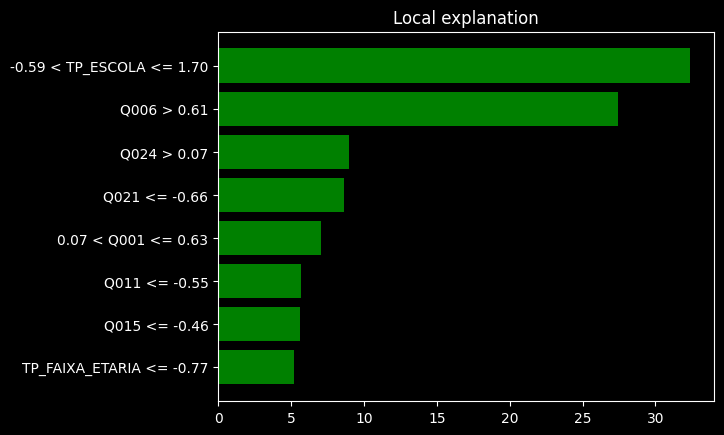

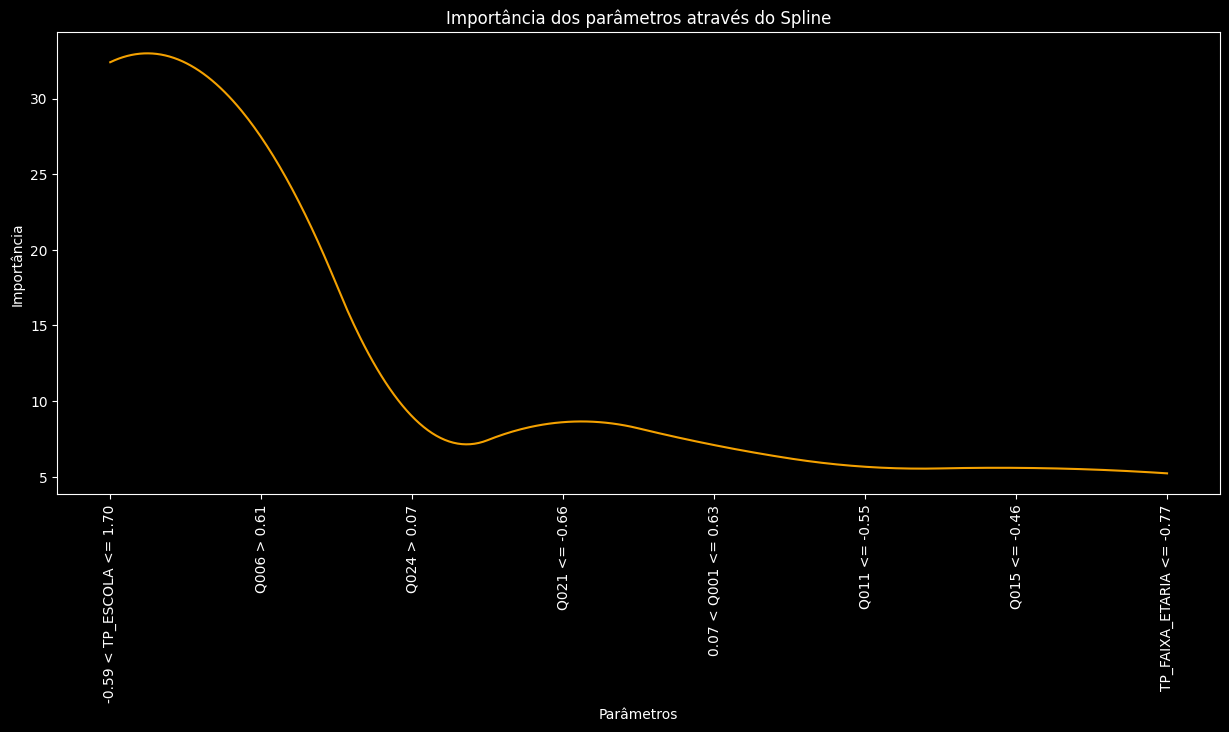

Computing partial dependence plots and individual conditional expectation...
done in 9.045s


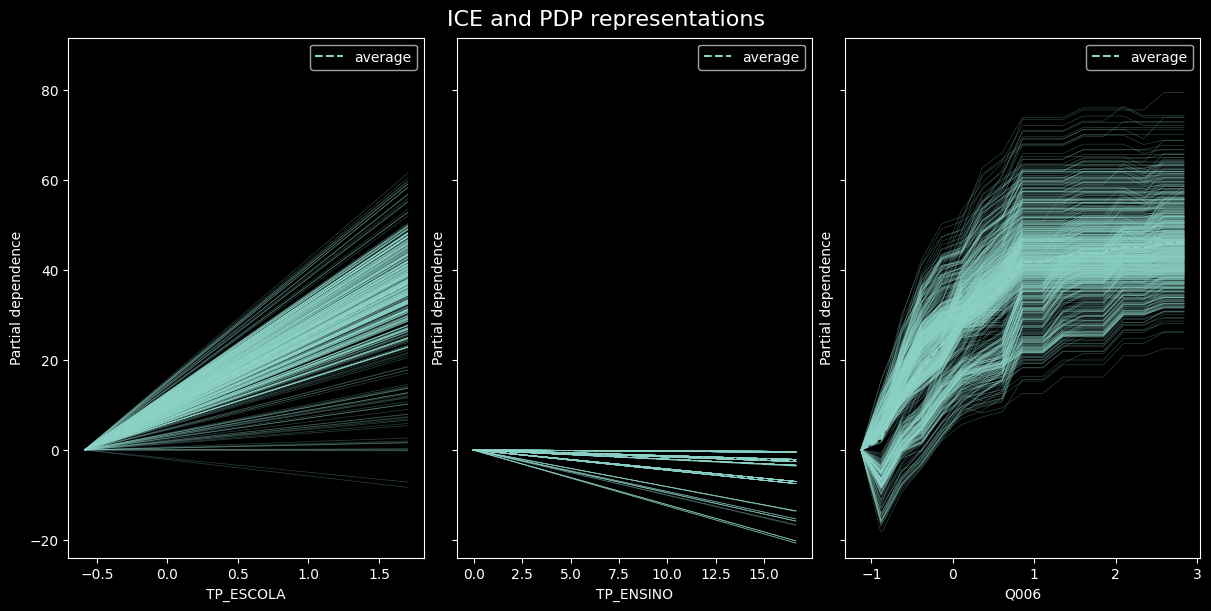

In [ ]:
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)
r2 = r2_score(y_test, predictions)
print("R² Score:", r2)

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X.columns, class_names=['price'], verbose=True, mode='regression', random_state = 1)
idx = 0
exp = explainer.explain_instance(X_test.values[idx], Boosting.predict, num_features=8)

exp.as_pyplot_figure()
plt.show()

feature_importance = exp.as_list()
features, importances = zip(*feature_importance)
features = np.array(features)
importances = np.array(importances)

x = np.arange(len(features))
spl = make_interp_spline(x, importances, k=2)
x_new = np.linspace(x.min(), x.max(), 500)
y_smooth = spl(x_new)

plt.figure(figsize=(15, 6))
plt.plot(x_new, y_smooth, color = '#F4A100')
plt.xticks(x, features, rotation=90)
plt.xlabel('Parâmetros')
plt.ylabel('Importância')
plt.title('Importância dos parâmetros através do Spline')
plt.show()

tic = time.time()
_, ax = plt.subplots(ncols=3, figsize=(12, 6), sharey=True, constrained_layout=True)

features_info = {
    "features": [4, 5, 11],
    "kind": "both",
    "centered": True,
}

display = PartialDependenceDisplay.from_estimator(
    Boosting,
    X_train,
    **features_info,
    ax=ax,
)
print(f"done in {time.time() - tic:.3f}s")
_ = display.figure_.suptitle("ICE and PDP representations", fontsize=16)
plt.show()

### Redes neurais

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Rn = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])


Rn.compile(optimizer='adam', loss='mean_squared_error')

Rn.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)

loss = Rn.evaluate(X_test_scaled, y_test)
print("Test Loss:", loss)

y_pred = Rn.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
print("Erro quadrático médio (MSE) no conjunto de teste:", mse)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 82900.2344 - val_loss: 6170.9888
Epoch 2/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 5942.3389 - val_loss: 5794.9526
Epoch 3/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 5642.7930 - val_loss: 5555.0098
Epoch 4/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 5547.9878 - val_loss: 5531.7275
Epoch 5/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 5542.9399 - val_loss: 5522.2505
Epoch 6/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 5482.3540 - val_loss: 5538.6353
Epoch 7/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 5482.8765 - val_loss: 5493.0811
Epoch 8/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 5518.4868 - val_loss: 5485.2354
Epoch 9/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 5433.6587 - val_loss: 5499.4766
Epoch 10/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 5380.5015 - val_loss: 5445.0254
Epoch 11/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step 

In [ ]:
r2 = r2_score(y_test, y_pred)
print("R² Score:", r2)

R² Score: 0.32356593045553195


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Intercept 447.15364594598003
Prediction_local [539.89115925]
Right: 647.9638


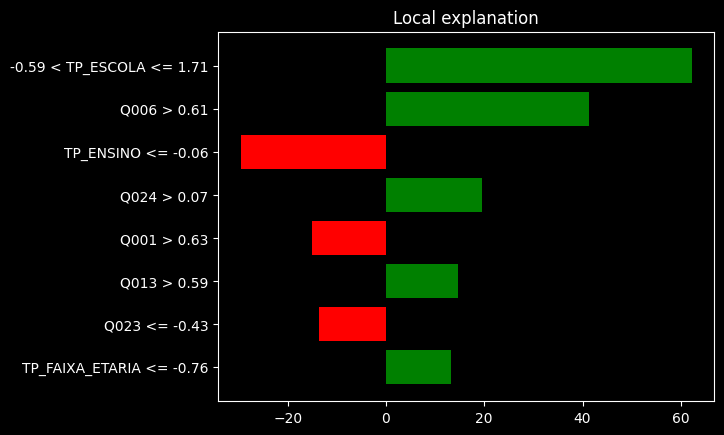

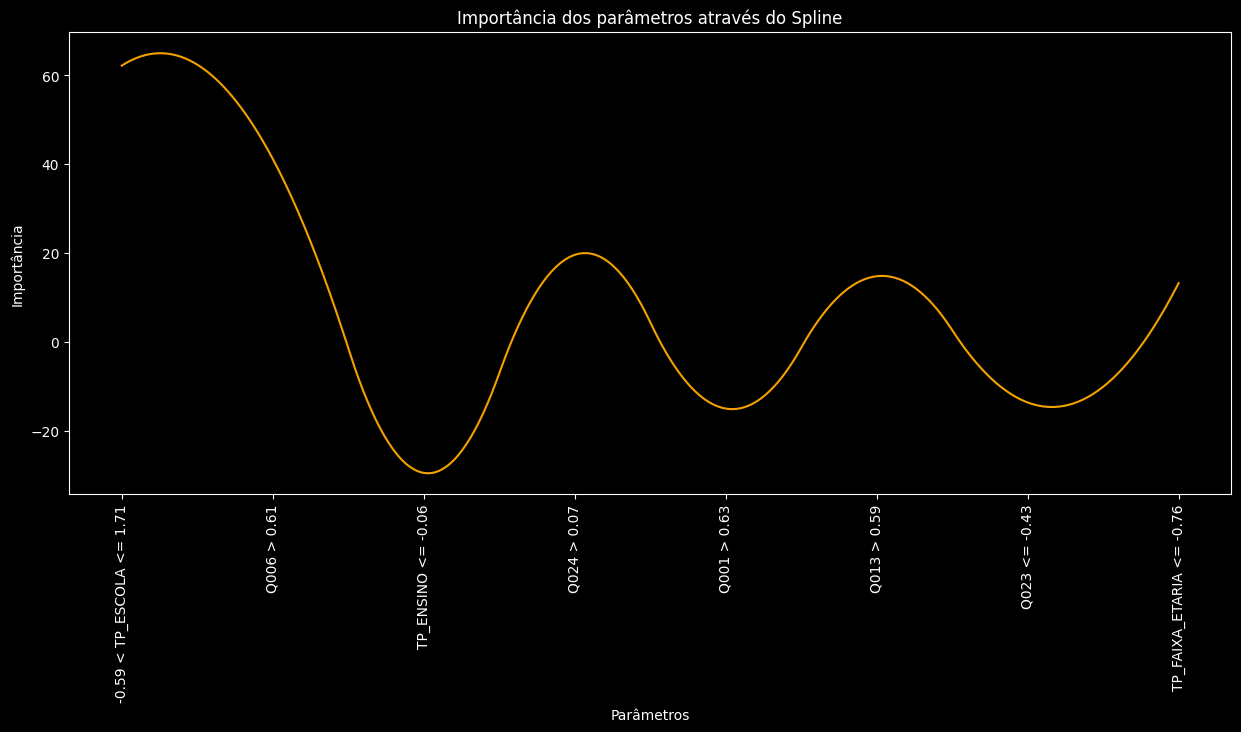

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train_scaled, feature_names= X.columns, class_names=['price'], verbose=True, mode='regression', random_state = 1)
idx = 0
exp = explainer.explain_instance(X_test.values[idx], Rn.predict, num_features=8)

exp.as_pyplot_figure()
plt.show()

feature_importance = exp.as_list()
features, importances = zip(*feature_importance)
features = np.array(features)
importances = np.array(importances)

x = np.arange(len(features))
spl = make_interp_spline(x, importances, k=2)
x_new = np.linspace(x.min(), x.max(), 500)
y_smooth = spl(x_new)

plt.figure(figsize=(15, 6))
plt.plot(x_new, y_smooth, color = '#F4A100')
plt.xticks(x, features, rotation=90)
plt.xlabel('Parâmetros')
plt.ylabel('Importância')
plt.title('Importância dos parâmetros através do Spline')
plt.show()

## Resultados finais

In [2]:
data = {
    "Modelo": [
        "Floresta Aleatória",
        "K-Nearest Neighbours (KNN)",
        "Boosting",
        "Redes Neurais",
        "Mínimos Quadrados",
        "Forward Stepwise",
        "Lasso",
        "Ridge",
    ],
    "MSE": [
        5371.164, 5504.797, 5204.113, 5346.793, 5459.92, 5459.93, 5436.31, 5436.25
    ],
    "R²": [
        0.328, 0.311, 0.349, 0.331, 0.322, 0.322, 0.320, 0.321
    ],
}

df = pd.DataFrame(data)

df.sort_values(by=["MSE"], ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

df

,Modelo,MSE,R²
0,Boosting,5204.113,0.349
1,Redes Neurais,5346.793,0.331
2,Floresta Aleatória,5371.164,0.328
3,Ridge,5436.250,0.321
4,Lasso,5436.310,0.320
5,Mínimos Quadrados,5459.920,0.322
6,Forward Stepwise,5459.930,0.322
7,K-Nearest Neighbours (KNN),5504.797,0.311


Baseando-se no menor MSE e maior R², o melhor modelo é o Boosting, que pertence à categoria de modelos não paramétricos. Isso sugere que modelos não paramétricos podem capturar melhor as relações não lineares ou complexas presentes nos dados. Por outro lado, os modelos paramétricos (como Ridge e Mínimos Quadrados) têm desempenho competitivo, mas geralmente assumem suposições mais rígidas sobre a estrutura dos dados. A escolha final dependerá do contexto mas, dados os resultados obtidos, os modelos não paramétricos aparentam ser mais adequados, inclusive por serem mais flexíveis em cenários com complexidade elevada.